In [1]:
from get_file_matches import get_tif_file_matches
from load_train_eval import load_data, train_and_evaluate, visualize_prediction, evaluate_predictions

from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import numpy as np

In [2]:
def build_hrnet_with_attention_unet(input_shape):
    inputs = layers.Input(input_shape)

    # Encoder with Squeeze-and-Excitation (SE) blocks
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(inputs)
    c1 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c1)
    c1 = squeeze_excitation_block(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(p1)
    c2 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c2)
    c2 = squeeze_excitation_block(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(p2)
    c3 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c3)
    c3 = squeeze_excitation_block(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)

    # Bottleneck
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(p3)
    c4 = layers.Conv2D(512, (3, 3), activation="relu", padding="same")(c4)
    c4 = squeeze_excitation_block(c4)

    # Decoder
    u3 = layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same")(c4)
    u3 = layers.Concatenate()([u3, c3])
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(u3)
    c5 = layers.Conv2D(256, (3, 3), activation="relu", padding="same")(c5)
    c5 = squeeze_excitation_block(c5)

    u2 = layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same")(c5)
    u2 = layers.Concatenate()([u2, c2])
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(u2)
    c6 = layers.Conv2D(128, (3, 3), activation="relu", padding="same")(c6)
    c6 = squeeze_excitation_block(c6)

    u1 = layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same")(c6)
    u1 = layers.Concatenate()([u1, c1])
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(u1)
    c7 = layers.Conv2D(64, (3, 3), activation="relu", padding="same")(c7)
    c7 = squeeze_excitation_block(c7)

    # Final Output
    outputs = layers.Conv2D(1, (1, 1), activation="sigmoid")(c7)

    return models.Model(inputs, outputs)


# Squeeze-and-Excitation Block
def squeeze_excitation_block(input_tensor, ratio=16):
    channel_axis = -1
    filters = input_tensor.shape[channel_axis]
    se = layers.GlobalAveragePooling2D()(input_tensor)
    se = layers.Reshape((1, 1, filters))(se)
    se = layers.Dense(filters // ratio, activation="relu", use_bias=False)(se)
    se = layers.Dense(filters, activation="sigmoid", use_bias=False)(se)
    return layers.Multiply()([input_tensor, se])


In [3]:
root_dir = "data/Tschernitz"
folder1 = "output"
folder2 = "ground_truth_masks/forest_masks"

# Match stacked TIF and ground truth mask
matches = get_tif_file_matches(root_dir, folder1, folder2, contains1="final_input", contains2="merged")

# Load Data and Train
X, Y = load_data(matches)

# Normalize inputs and binarize ground truth masks
X = X / 255.0
Y = (Y > 0).astype(np.float32)

Folder1 Path: data/Tschernitz\output
Folder2 Path: data/Tschernitz\ground_truth_masks/forest_masks


In [4]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=42)

Epoch 1/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 16s 4s/step - accuracy: 0.5486 - loss: 0.6941 - val_accuracy: 0.6195 - val_loss: 0.6914
Epoch 2/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6119 - loss: 0.6927 - val_accuracy: 0.6852 - val_loss: 0.6902
Epoch 3/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6489 - loss: 0.6900 - val_accuracy: 0.6458 - val_loss: 0.6839
Epoch 4/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 4s/step - accuracy: 0.5909 - loss: 0.6848 - val_accuracy: 0.6777 - val_loss: 0.6732
Epoch 5/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.6452 - loss: 0.6778 - val_accuracy: 0.7210 - val_loss: 0.6556
Epoch 6/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.6529 - loss: 0.6584 - val_accuracy: 0.6959 - val_loss: 0.6162
Epoch 7/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.6734 - loss: 0.6164 - val_accuracy: 0.7836 - val_loss: 0.5424
Epoch 8/25
2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.7730 - loss: 0.6260 - val_accuracy: 0.7634 - val_loss: 0.5426
Epoch 9/25
2/2 

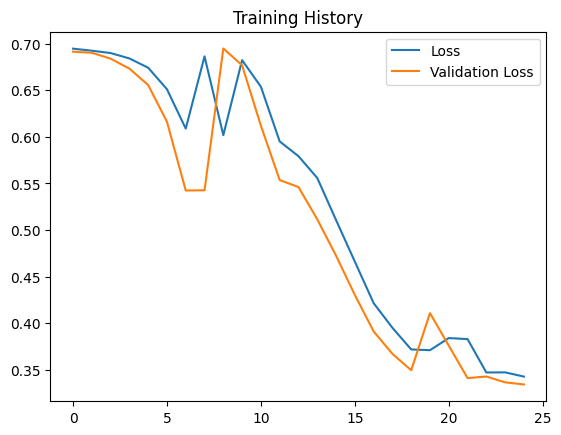

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


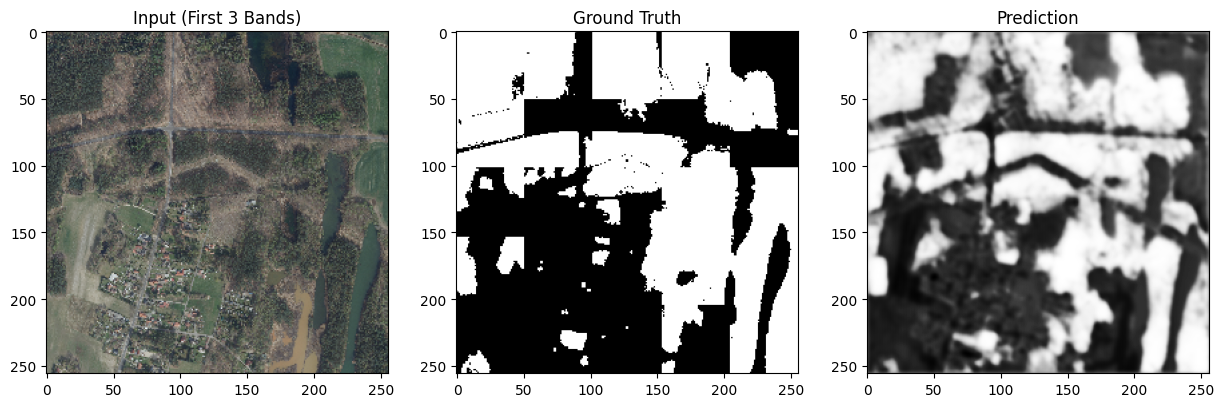

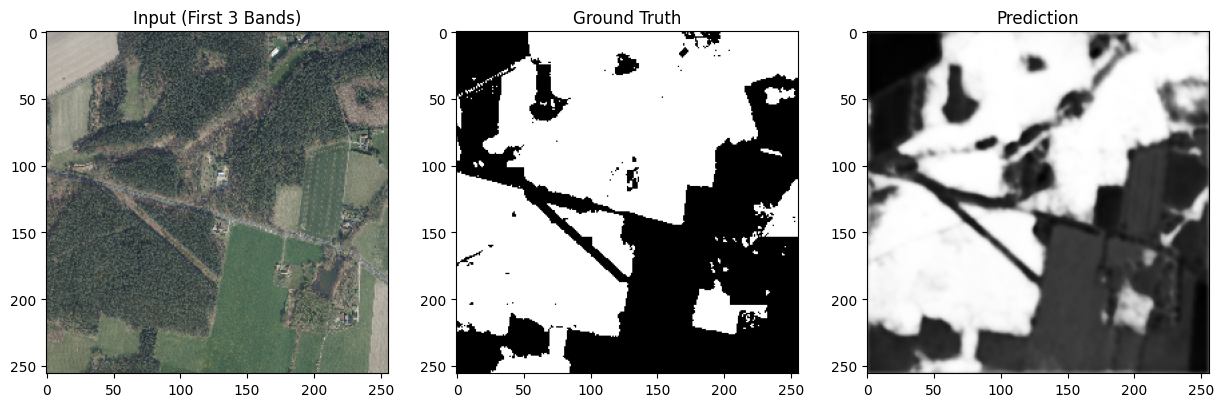

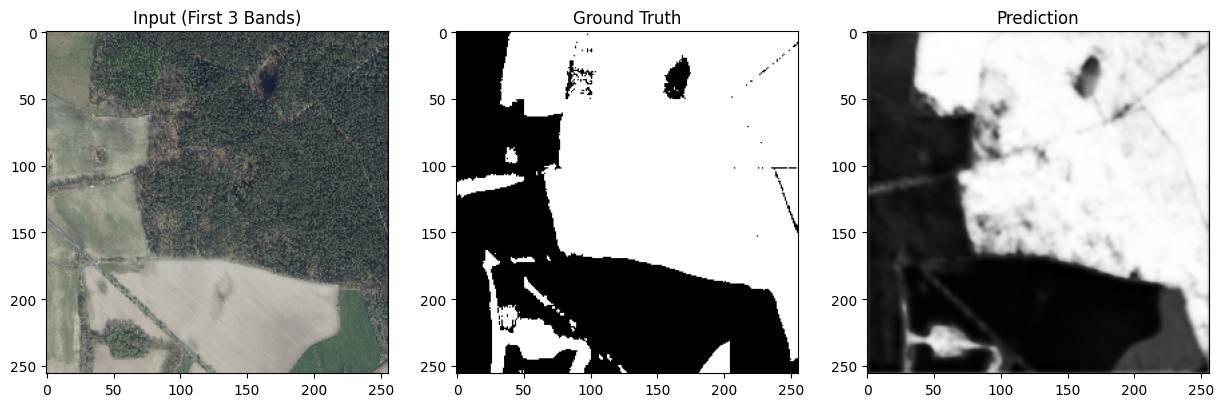

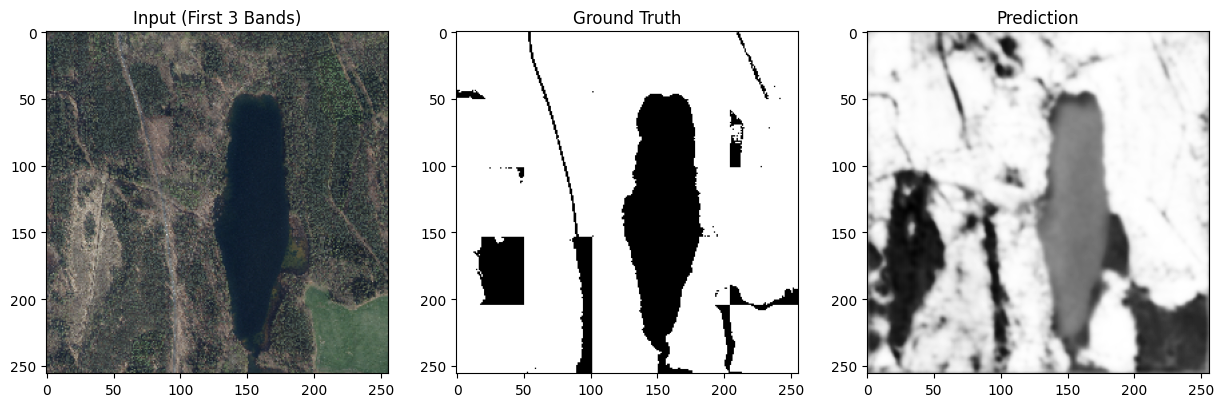

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 560ms/step

==== Model Evaluation Metrics ====
IoU: 0.7769
Dice: 0.8714
Accuracy: 0.8443
Precision: 0.8905
Recall: 0.8537


In [5]:
# Re-train HRNet with the adjusted architecture
hrnet_results_full = train_and_evaluate(X_train, Y_train, X_val, Y_val, build_hrnet_with_attention_unet, batch_size=8, epochs=25)

Epoch 1/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step - accuracy: 0.4424 - loss: 0.6939 - val_accuracy: 0.7783 - val_loss: 0.6906
Epoch 2/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.6950 - loss: 0.6907 - val_accuracy: 0.7842 - val_loss: 0.6864
Epoch 3/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7657 - loss: 0.6856 - val_accuracy: 0.7464 - val_loss: 0.6783
Epoch 4/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 13s 4s/step - accuracy: 0.7844 - loss: 0.6730 - val_accuracy: 0.7851 - val_loss: 0.6476
Epoch 5/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 21s 3s/step - accuracy: 0.7908 - loss: 0.6371 - val_accuracy: 0.7812 - val_loss: 0.5778
Epoch 6/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 3s/step - accuracy: 0.7157 - loss: 0.6549 - val_accuracy: 0.7510 - val_loss: 0.5693
Epoch 7/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 4s/step - accuracy: 0.7191 - loss: 0.5868 - val_accuracy: 0.6816 - val_loss: 0.6152
Epoch 8/25
4/4 ━━━━━━━━━━━━━━━━━━━━ 14s 4s/step - accuracy: 0.7684 - loss: 0.5762 - val_accuracy: 0.7761 - val_loss: 0.5745
Epoch 9/

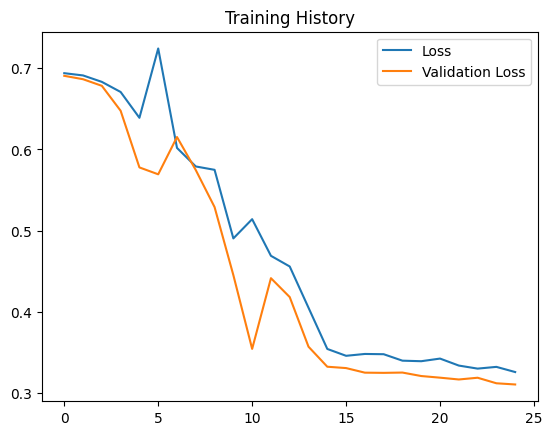

Evaluating model...
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


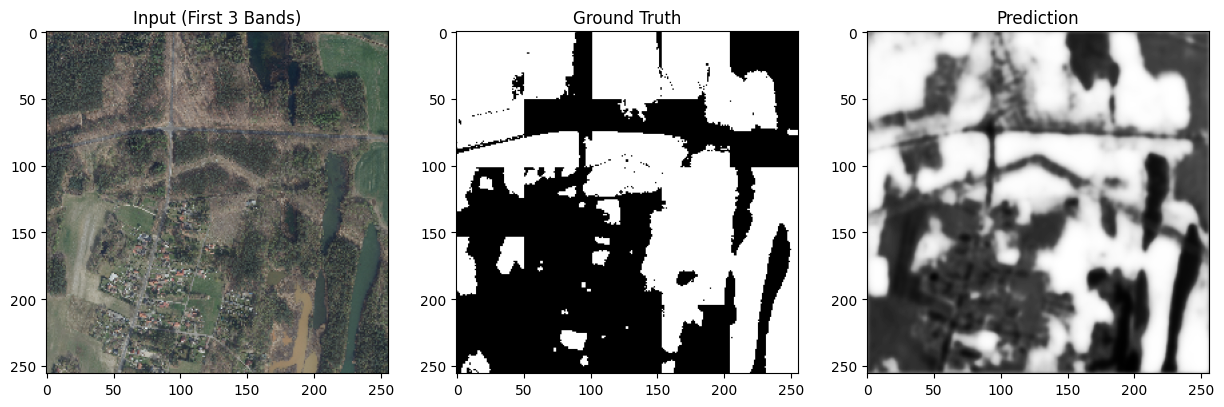

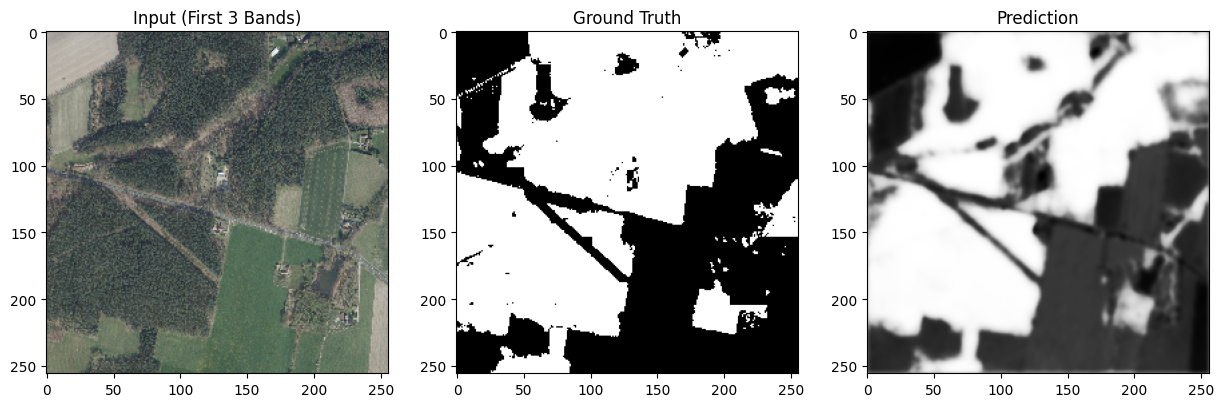

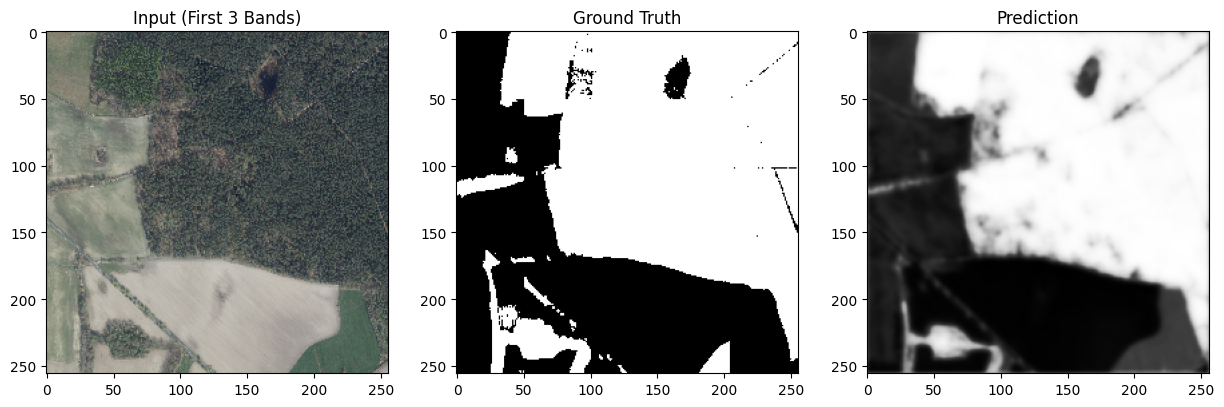

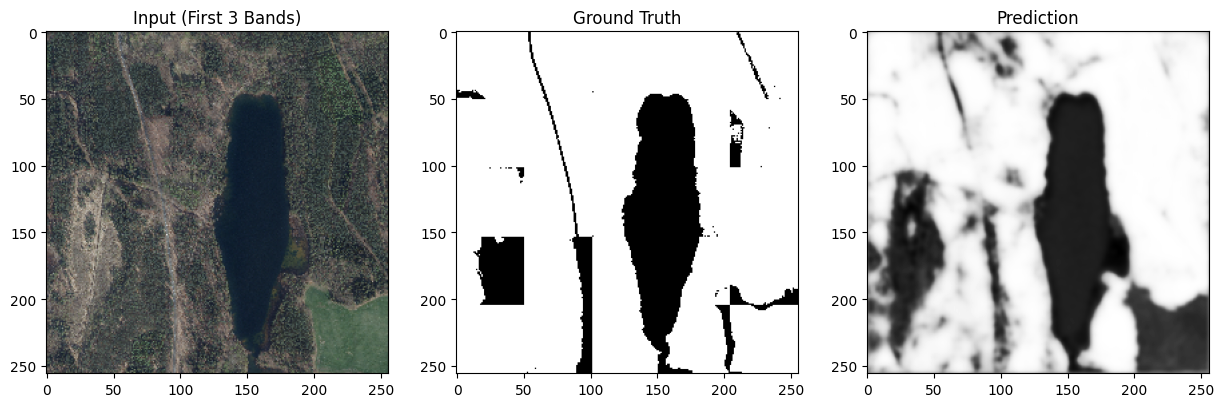

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step

==== Model Evaluation Metrics ====
IoU: 0.8048
Dice: 0.8884
Accuracy: 0.8705
Precision: 0.9102
Recall: 0.8688


In [6]:
# Re-train HRNet with the adjusted architecture
hrnet_results_full = train_and_evaluate(X_train, Y_train, X_val, Y_val, build_hrnet_with_attention_unet, batch_size=4, epochs=25, learning_rate=1e-3)

In [7]:
from augmentation_pipeline import augment_dataset, plot_original_and_augmented_versions

augment_configs = [
    {"RandomRotate90": 0.5, "HorizontalFlip": 0.5},
    {"ShiftScaleRotate": {"shift_limit": 0.01, "scale_limit": 0.05, "rotate_limit": 15, "p": 0.5}},
    {"RandomBrightnessContrast": {"brightness_limit": 0.1, "contrast_limit": 0.1, "p": 0.5}},
    {"GaussNoise": {"var_limit": (5.0, 25.0), "p": 0.3}},
]
"""results = {}
for i, config in enumerate(augment_configs):
    print(f"\nApplying Augmentation Configuration {i+1}/{len(augment_configs)}: {config}")
    X_train_aug, Y_train_aug = augment_dataset(X_train, Y_train, config, num_versions=2)
    results[f"Config_{i+1}"] = train_and_evaluate(X_train_aug, Y_train_aug, X_val, Y_val, build_hrnet_with_attention_unet, batch_size=4, epochs=25, learning_rate=1e-3, visualize=False)
"""
# Plot the first 3 images and their augmented versions
#plot_original_and_augmented_versions(X_train[:3], X_train_aug, num_samples=3, num_versions=5)

'results = {}\nfor i, config in enumerate(augment_configs):\n    print(f"\nApplying Augmentation Configuration {i+1}/{len(augment_configs)}: {config}")\n    X_train_aug, Y_train_aug = augment_dataset(X_train, Y_train, config, num_versions=2)\n    results[f"Config_{i+1}"] = train_and_evaluate(X_train_aug, Y_train_aug, X_val, Y_val, build_hrnet_with_attention_unet, batch_size=4, epochs=25, learning_rate=1e-3, visualize=False)\n'